# Learning to Control Burgers Equation with Differentiable Physics
This notebook will walk you through data generation, supervised network initialization and end-to-end training using our differentiable PDE solver, [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow).

The code below replicates experiment 1 from the ICLR 2020 paper [Learning to Control PDEs with Differentiable Physics](https://ge.in.tum.de/publications/2020-iclr-holl/). The original experiment was performed on an older version of the solver, the code for which can be found under `/legacy`.

In [1]:
import sys, os

# Go one directory up from notebooks/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
phiflow_path = os.path.join(project_root, 'PhiFlow')

sys.path.insert(0, src_path)
sys.path.insert(0, phiflow_path)

In [2]:
from control.pde.burgers import GaussianClash, GaussianForce
import burgers_plots as bplt
import matplotlib.pyplot as plt
from phi.flow import *

/home/soeren/.pyenv/versions/pde36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/soeren/.pyenv/versions/pde36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/soeren/.pyenv/versions/pde36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/soeren/.pyenv/versions/pde36/lib/python3

Could not load resample cuda libraries: CUDA binaries not found at /home/soeren/.pyenv/versions/3.6.15/envs/pde36/lib/python3.6/site-packages/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them


/home/soeren/.pyenv/versions/pde36/lib/python3.6/site-packages/phi/viz/dash/dash_gui.py:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/home/soeren/.pyenv/versions/pde36/lib/python3.6/site-packages/phi/viz/dash/dash_gui.py:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


/home/soeren/.pyenv/versions/3.6.15/lib/python3.6/_collections_abc.py:743: MatplotlibDeprecationWarning:

The global colormaps dictionary is no longer considered public API.

/home/soeren/.pyenv/versions/3.6.15/lib/python3.6/_collections_abc.py:744: MatplotlibDeprecationWarning:

The global colormaps dictionary is no longer considered public API.

/home/soeren/.pyenv/versions/pde36/lib/python3.6/site-packages/phi/tf/flow.py:14: UserWarning:

TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run
$ python setup.py tf_cuda
before reinstalling phiflow.



## Data Generation

In [3]:
domain = Domain([128], box=box[0:1])  # 1D Grid resolution and physical size
viscosity = 0.003  # Viscosity constant for Burgers equation
step_count = 32  # how many solver steps to perform
dt = 0.03  # Time increment per solver step

Let's have a look at an example Burgers simulation with Gaussian forcing. The classes `BurgersVelocity` and `Burgers` are part of the Φ<sub>Flow</sub> library.

*Hint: You can execute the cell below multiple times to get different results. Both `GaussianClash` and `GaussianForce` use random numbers internally.*

Force: 0.721318 at 0.402643


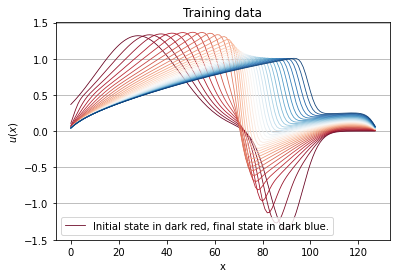

In [4]:
# --- Set up physics ---
world = World()
u0 = BurgersVelocity(domain, velocity=GaussianClash(1), viscosity=viscosity)
u = world.add(u0, physics=Burgers(diffusion_substeps=4))
force = world.add(FieldEffect(GaussianForce(1), ['velocity']))
# --- Plot ---
print('Force: %f at %f' % (force.field.amp[0], force.field.loc[0]))
bplt.burgers_figure('Training data')
plt.plot(u.velocity.data[0,:,0], color=bplt.gradient_color(0, step_count+1), linewidth=0.8)  # data[example, values, component]
plt.legend(['Initial state in dark red, final state in dark blue.'])
for frame in range(1, step_count + 1):
    world.step(dt=dt)  # runs one simulation step
    plt.plot(u.velocity.data[0,:,0], color=bplt.gradient_color(frame, step_count+1), linewidth=0.8)

Next, we define how many examples to generate and where to store them.

In [5]:
data_path = 'forced-burgers-clash'
scene_count = 1000  # how many examples to generate (training + validation + test)
batch_size = 100  # How many examples to generate in parallel

The following cell will generate and store the data.

In [6]:
for batch_index in range(scene_count // batch_size):
    scene = Scene.create(data_path, count=batch_size)
    print(scene)
    world = World()
    u0 = BurgersVelocity(domain, velocity=GaussianClash(batch_size), viscosity=viscosity, batch_size=batch_size, name='burgers')
    u = world.add(u0, physics=Burgers(diffusion_substeps=4))
    force = world.add(FieldEffect(GaussianForce(batch_size), ['velocity']))
    scene.write(world.state, frame=0)
    for frame in range(1, step_count + 1):
        world.step(dt=dt)
        scene.write(world.state, frame=frame)

/home/soeren/.pyenv/versions/pde36/lib/python3.6/site-packages/phi/data/fluidformat.py:293: UserWarning:

Failed to copy calling script to scene during Scene.create().
Cause: [Errno 2] No such file or directory: '<ipython-input-6-ff3451c0a400>'



forced-burgers-clash/sim_000000
forced-burgers-clash/sim_000100
forced-burgers-clash/sim_000200
forced-burgers-clash/sim_000300
forced-burgers-clash/sim_000400
forced-burgers-clash/sim_000500
forced-burgers-clash/sim_000600
forced-burgers-clash/sim_000700
forced-burgers-clash/sim_000800
forced-burgers-clash/sim_000900


To delete the generated data, uncomment and run the cell below.

In [7]:
for scene in Scene.list(data_path): scene.remove()

# Supervised Initialization

We can use a supervised observation loss to initialize the observation prediction (OP) networks.
This teaches them to reproduce the simulations from the training data.

In [ ]:
from control.pde.burgers import BurgersPDE
from control.control_training import ControlTraining
from control.sequences import StaggeredSequence, RefinedSequence

Define what part of the data is used for training, validation and testing.

In [ ]:
test_range = range(100)
val_range = range(100, 200)
train_range = range(200, 1000)

The following cell trains all OP$_n \,\, \forall n\in\{2,4,8,16,32\}$.
The `ControlTraining` class is used to set up the optimization problem.

The loss for the supervised initialization is defined as the observation loss at the center frame.

$\boldsymbol L_o^\textrm{sup} = \left|\mathrm{OP}[o(t_i),o(t_j)] - u^\textrm{GT}\left(\frac{t_i+t_j}{2}\right)\right|^2.$

Consequently, no sequence needs to be simulated (`sequence_class=None`) and an observation loss is required at frame $\frac n 2$ (`obs_loss_frames=[n // 2]`).
The pretrained network checkpoints are stored in `supervised_checkpoints`.

*Note: The next cell will run for some time. You can skip it and load the pretrained networks instead (see instructions below).*

In [ ]:
supervised_checkpoints = {}

for n in [2, 4, 8, 16, 32]:
    app = ControlTraining(n,
                          BurgersPDE(domain, viscosity, dt),
                          datapath=data_path,
                          val_range=val_range,
                          train_range=train_range,
                          trace_to_channel=lambda trace: 'burgers_velocity',
                          obs_loss_frames=[n // 2],
                          trainable_networks=['OP%d' % n],
                          sequence_class=None,
                          batch_size=100,
                          view_size=20,
                          learning_rate=1e-3,
                          learning_rate_half_life=1000,
                          dt=dt).prepare()
    # show(app, force_launch=True)  # launches the Φ-Flow web interface
    for i in range(3000):
        app.progress()  # Run Optimization for one batch
    supervised_checkpoints['OP%d' % n] = app.save_model()

In [ ]:
supervised_checkpoints

If you have already initialized the networks, you can simply copy the `supervised_checkpoints` by pasting the output above into the cell below.

In [ ]:
# supervised_checkpoints = 

Or load the pretrained networks that are included in the repository by uncommenting and running the cell below.

In [ ]:
# supervised_checkpoints = {'OP%d'%n: '../networks/burgers/supervised/OP%d_3000'%n for n in [2,4,8,16,32]}

Note that we have not actually set up a simulation for the training. To evaluate the quality of our current solutions, we will use the `ControlTraining` class again but this time passing a `sequence_class`.
With a sequence class, `ControlTraining` sets up the necessary physics steps and networks.
Example sequence classes are `StaggeredSequence` and `RefinedSequence`.

In [ ]:
supervised_staggered_app = ControlTraining(
                            32,
                            BurgersPDE(domain, viscosity, dt),
                            datapath=data_path,
                            val_range=val_range,
                            train_range=train_range,
                            trace_to_channel=lambda trace: 'burgers_velocity',
                            obs_loss_frames=[],
                            trainable_networks=[],
                            sequence_class=StaggeredSequence,
                            batch_size=100,
                            view_size=20,
                            learning_rate=1e-3,
                            learning_rate_half_life=1000,
                            dt=dt).prepare()
supervised_staggered_app.load_checkpoints(supervised_checkpoints)

We can have a look at the force required to exactly match the target in our test set.

*Note:* The property `'Total Force'` is created by `BurgersPDE`.

In [ ]:
print('Total Force (supervised): %f' % supervised_staggered_app.infer_scalars(test_range)['Total Force'])

Let's have a look at some of the reconstructed sequences. Change the `test_range` indices to look at different examples.

In [ ]:
states = supervised_staggered_app.infer_all_frames(test_range[0:1])
bplt.burgers_figure('Supervised')
for frame in range(0, step_count + 1):
    plt.plot(states[frame].burgers.velocity.data[0,:,0], color=bplt.gradient_color(frame, step_count+1), linewidth=0.8)

# End-to-end Training with Differentiable Physics

To initiale training with the differentiable physics loss, we create a new `ControlTraining` instance with the staggered execution scheme.

The following cell trains all OP networks jointly to minimize the force (see the `trainable_networks` parameter). You can increase the number of optimization steps or execute the next cell multiple times to further increase performance.

*Note: The next cell will run for some time. You can skip the next two cells and load the pretrained networks instead.*

In [ ]:
staggered_app = ControlTraining(
                            32,
                            BurgersPDE(domain, viscosity, dt),
                            datapath=data_path,
                            val_range=val_range,
                            train_range=train_range,
                            trace_to_channel=lambda trace: 'burgers_velocity',
                            obs_loss_frames=[],
                            trainable_networks=['OP%d' % n for n in [2,4,8,16,32]],
                            sequence_class=StaggeredSequence,
                            batch_size=100,
                            view_size=20,
                            learning_rate=1e-3,
                            learning_rate_half_life=1000,
                            dt=dt).prepare()

In [ ]:
for i in range(3000):
    staggered_app.progress()

In [ ]:
staggered_checkpoint = staggered_app.save_model()
staggered_checkpoint

To load the pretrained networks included in this repository, uncomment and execute the cell below.

In [ ]:
#staggered_app.load_checkpoints({'OP%d'%n: '../networks/burgers/staggered/OPn_18000' for n in [2,4,8,16,32]})

Let's evaluate the performance of our networks after end-to-end training.

In [ ]:
print('Total Force (diff. phys. / staggered): %f' % staggered_app.infer_scalars(test_range)['Total Force'])
states = staggered_app.infer_all_frames(test_range[0:1])
bplt.burgers_figure('Staggered execution')
for frame in range(0, step_count + 1):
    plt.plot(states[frame].burgers.velocity.data[0,:,0], color=bplt.gradient_color(frame, step_count+1), linewidth=0.8)

To evaluate our models using the prediction refinement scheme, we repeat the above steps but using a `RefinedSequence` instead of a `StaggeredSequence`.

In [ ]:
refined_app = ControlTraining(step_count,
                      BurgersPDE(domain, viscosity, dt),
                      datapath=data_path,
                      val_range=val_range,
                      train_range=train_range,
                      trace_to_channel=lambda trace: 'burgers_velocity',
                      obs_loss_frames=[],
                      trainable_networks=['OP%d' % n for n in [2,4,8,16,32]],
                      sequence_class=RefinedSequence,
                      batch_size=100,
                      view_size=20,
                      learning_rate=1e-3,
                      learning_rate_half_life=1000,
                      dt=dt).prepare()

To load the weights we just trained, run the cell below.

To load the pretrained weights, skip the next cell and uncomment and run the one after that.

In [ ]:
refined_app.load_checkpoints({'OP%d' % n: staggered_checkpoint for n in [2,4,8,16,32]})

In [ ]:
#refined_app.load_checkpoints({'OP%d'%n: '../networks/burgers/staggered/OPn_18000' for n in [2,4,8,16,32]})

We could still refine training at this point by repeatedly calling `refined_app.progress()`.
Here, we show that the prediction refinement scheme beats the staggered execution, despite not being trained with that architecture.

In [ ]:
print('Total Force (diff. phys. / refined): %f' % refined_app.infer_scalars(test_range)['Total Force'])
states = refined_app.infer_all_frames(test_range[0:1])
bplt.burgers_figure('Prediction refinement')
for frame in range(0, step_count + 1):
    plt.plot(states[frame].burgers.velocity.data[0,:,0], color=bplt.gradient_color(frame, step_count+1), linewidth=0.8)